<a href="https://colab.research.google.com/github/TeAmP0is0N/Fake-News-Hindi/blob/master/Data%20Analysis/NewsDataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import sys
sys.path.append('/gdrive/My Drive/IIITD Fake News Project/Notebooks/Data Analysis')

In [3]:
import re
import tweepy
import difflib
import pandas as pd
import numpy as np
import pickle
import time
import copy
import matplotlib.pyplot as plt
from datetime import date
from collections import Counter 

In [4]:
####input your credentials here
access_token = "103589925-PYiNRi6sAoSAFCau7Q5zDAqF7Kt8WwsK5EunWL3I"
access_token_secret = "u8N1nS93eN5npmtBOAxCwJgZE0W4wPCNe1CEuCB9lEIys"
consumer_key = "IIFBxSZv8YnhRJuvvDJVkR4ht"
consumer_secret = "zou3XOVMDXp9esingDNEowUeEPmTKkY4daZGYdmalovyd9JCxr"

In [5]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

In [6]:
pd.options.display.max_colwidth = 0

In [7]:
### List of Hindi Stopwords

stopwords = []

file = open("/gdrive/My Drive/IIITD Fake News Project/Notebooks/Data Analysis/final_stopwords.txt", 'r')
for word in file:
    word = word.split("\n")[0]
    stopwords.append(word)

print("Total number of stopwords in Hindi are: ",len(stopwords))
print(stopwords)

Total number of stopwords in Hindi are:  264
['मैं', 'मुझको', 'मेरा', 'अपने आप को', 'हमने', 'हमारा', 'अपना', 'हम', 'आप', 'आपका', 'तुम्हारा', 'अपने आप', 'स्वयं', 'वह', 'इसे', 'उसके', 'खुद को', 'कि वह', 'उसकी', 'उसका', 'खुद ही', 'यह', 'इसके', 'उन्होने', 'अपने', 'क्या', 'जो', 'किसे', 'किसको', 'कि', 'ये', 'हूँ', 'होता है', 'रहे', 'थी', 'थे', 'होना', 'गया', 'किया जा रहा है', 'किया है', 'है', 'पडा', 'होने', 'करना', 'करता है', 'किया', 'रही', 'एक', 'लेकिन', 'अगर', 'या', 'क्यूंकि', 'जैसा', 'जब तक', 'जबकि', 'की', 'पर', 'द्वारा', 'के लिए', 'साथ', 'के बारे में', 'खिलाफ', 'बीच', 'में', 'के माध्यम से', 'दौरान', 'से पहले', 'के बाद', 'ऊपर', 'नीचे', 'को', 'से', 'तक', 'से नीचे', 'करने में', 'निकल', 'बंद', 'से अधिक', 'तहत', 'दुबारा', 'आगे', 'फिर', 'एक बार', 'यहाँ', 'वहाँ', 'कब', 'कहाँ', 'क्यों', 'कैसे', 'सारे', 'किसी', 'दोनो', 'प्रत्येक', 'ज्यादा', 'अधिकांश', 'अन्य', 'में कुछ', 'ऐसा', 'में कोई', 'मात्र', 'खुद', 'समान', 'इसलिए', 'बहुत', 'सकता', 'जायेंगे', 'जरा', 'चाहिए', 'अभी', 'और', 'कर दिया', 'रखें', 'क

In [8]:
df = pd.read_csv("/gdrive/My Drive/IIITD Fake News Project/Data Set/Manual Annotations/Boomlive Manual Annotation.xlsx - Sheet1.csv")
df.drop(df.columns[[7,8,9,10,11,12,13,14,15,16]], axis = 1, inplace = True)
df

,Article Link,Title,Content,Source,Domain,Date,Category
0,https://hindi.boomlive.in/fake-news/facebook-posts-claiming-pm-wore-footwear-during-bhumi-pujan-are-false-9222,"नहीं, भूमि पूजन के दौरान प्रधानमंत्री नरेंद्र मोदी ने चप्पल नहीं पहन...","चप्पल पहनकर भूमि पूजन, आखिर कितनी धज्जियां उड़ाओगे हिंदू धर्म की ! पैरों में चप्पल पहनकर कोई भूमि पूजन होता है क्या?\nये किस मानसिकता के भक्त है मित्रो | चप्पल जूता पहनकर भूमि पूजनवाह👌मोदी हे तो मुमकिन हैं नकली राम भक्त",Miscellaneous,https://hindi.boomlive.in/fake-news/,8 August 2020 4:46 PM,Politics
1,https://hindi.boomlive.in/fake-news/delhis-killer-doctors-story-viral-with-fake-covid-19-twist-9188,दिल्ली के हत्यारे डॉक्टर की कहानी फ़र्ज़ी कोविड-19 कोण के साथ वायरल,स्वस्थ आदमी को कोरोना पेशेंट बता कर अब तक 125 लोगो का किडनी निकाल कर हत्या करने वाला डॉ देवेन्द्र शर्मा गिरफ्तार\nऐसे ना जाने कितने डॉ हमारे आपके बीच मे है जिससे हमलोगो को सतर्क रहना होगा और अपने लोगो का ख्याल रखना होगा | किसी भी स्वस्थ इन्शान की कोरोना से मौत होती है तो डॉ द्वरा लपेटे हुवे बॉडी को दूर से ही सही पर चैक जरूर करे |,Miscellaneous,https://hindi.boomlive.in/fake-news/,6 Aug 2020 3:31 PM,Crime
2,https://hindi.boomlive.in/fake-news/video-from-hyderabad-temple-viral-with-ram-mandir-bhumi-pujan-twist-9178,हैदराबाद के मंदिर का वीडियो राम मंदिर अयोध्या के नाम पर हो रहा वायरल,यह वीडियो अयोध्या में राम मंदिर के भूमि पूजन की तैयारी दिखाता है\n\n,Miscellaneous,https://hindi.boomlive.in/fake-news/,5 Aug 2020 7:13 PM,Politics
3,https://hindi.boomlive.in/fake-news/2018-images-of-alleged-kidney-theft-in-up-revived-with-covid-19-spin-9176,कथित किडनी चोरी की दो साल पुरानी तस्वीरें कोविड-19 से जोड़कर की जा रही...,"मोदीजी @narendramodiकोरोना काल मे डॉक्टर को महान योद्धाओ के रूप मे बोल रहे थे,किन्तु उत्तर प्रदेश के मुजफ्फरनगर मे गर्ग हास्पीटल का एक डाक्टर कोरोना मरीज से गुर्दे निकाल कर बेचने का प्रयास करता पकड़ा गया। #मानवता खत्म हो गयी है डॉ के पेशे को कलंकित कर दिया । @myogiadityanath",Facebook,https://hindi.boomlive.in/fake-news/,5 Aug 2020 5:11 PM,COVID related
4,https://hindi.boomlive.in/fake-news/former-cji-ranjan-gogoi-denies-reports-of-testing-positive-for-covid-19-91755,"पूर्व CJI रंजन गोगोई Corona Positive, Ram Mandir के पक्ष में सुनाया था ऐतिहासिक फैसला",देश के पूर्व CJI रंजन गोगोई हुए Corona पॉजिटिव\n\nGaya 24x7 देश में कोरोनावायरस के मामले काफी तेजी से बढ़ रहे हैं. इसी कड़ी में भारत के पूर्व चीफ जस्टिस रंजन गोगोई भी कोरोना संक्रमित हो गए हैं. बता दें कि नंवबर 2019 में रंजन गोगोई की अध्यक्षता वाली बेंच ने ही राम मंदिर केस का फैसला सुनाया था.,Facebook,https://hindi.boomlive.in/fake-news/,5 Aug 2020 4:41 PM,COVID related
...,...,...,...,...,...,...,...
917,https://hindi.boomlive.in/fake-news/old-mock-funeral-video-falsely-linked-to-amit-shah-getting-covid-19-9287,प्रदर्शन के पुराने वीडियो को अमित शाह के कोविड-19 संक्रमण से जोड़कर...,इनकी मानसिकता देखिए अमित शाह जी के कोरोना संक्रमित होने पर उनकी शवयात्रा निकाल के खुशी मना रहे है..' |\n\n,Miscellaneous,https://hindi.boomlive.in/fake-news/,13 Aug 2020 5:50 PM,Politics
918,https://hindi.boomlive.in/fake-news/video-of-men-uprooting-saplings-in-pakistan-viral-with-islamophobic-claim-9273,पाकिस्तान में पौधे उखाड़ते लोगों का वीडियो 'इस्लामोफ़ोबिक' दावों के साथ...,इमरान खान ने प्रधानमंत्री श्री मोदी की ट्री प्लांटेशन ड्राइव की नक़ल पाकिस्तान में की पर उनके फॉलोवर्स ने पेड़ उखाड़ दिए क्योंकि वो सोचते हैं की पौधारोपण इस्लाम के ख़िलाफ है' |\n\n,Miscellaneous,https://hindi.boomlive.in/fake-news/,12 Aug 2020 7:05 PM,Politics
919,https://hindi.boomlive.in/fake-news/no-this-is-not-the-blueprint-of-the-babri-hospital-9244,"नहीं, यह बाबरी हॉस्पिटल का 'ब्लू प्रिंट' नहीं है",तस्वीर बाबरी हॉस्पिटल का ब्लू प्रिंट दिखाती है\n\n,Facebook,https://hindi.boomlive.in/fake-news/,10 Aug 2020 8:15 PM,Politics
920,https://hindi.boomlive.in/fake-news/did-historian-rana-safvi-claim-mughals-gave-birth-to-rakshabandhan-9240,क्या इतिहासकार राना सफ़वी ने अपने लेख में कहा है कि रक्षाबंधन मुग़लों ने ...,इतिहासकार राना सफ़वी ने कहा की राखी मुग़लों ने इज़ाद की है |\n\n,Miscellaneous,https://hindi.boomlive.in/fake-news/,10 Aug

In [9]:
df['Category'].value_counts()

Politics         327
Crime            193
Miscellaneous    159
COVID related    89 
Entertainment    61 
Education        17 
Technology       17 
Health           11 
Sports           10 
Lifestyle        10 
miscellaneous    8  
politics         8  
Finance          5  
Editorial        4  
crime            3  
Name: Category, dtype: int64

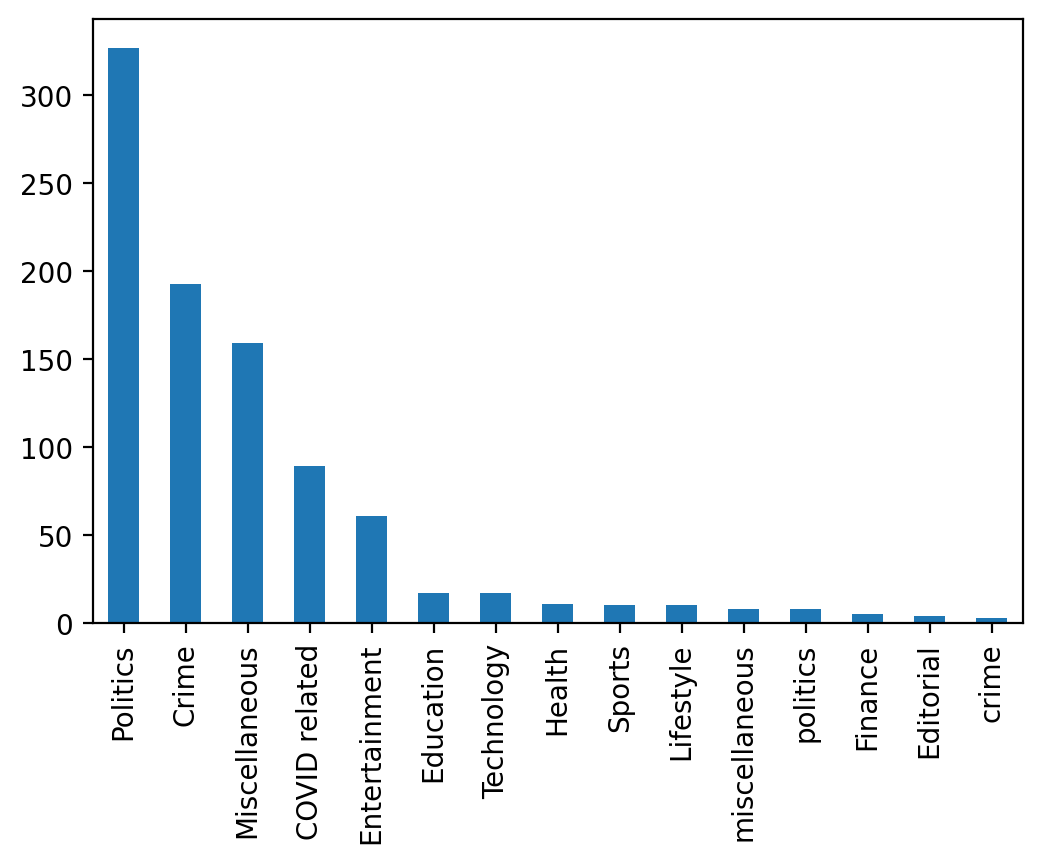

In [10]:
plt.figure(dpi=200)
df['Category'].value_counts().plot(kind='bar')

In [11]:
puncs           = [',', '|', '?', '-', ':', '_', '!', ';', '"' ]
all_words       = []
not_stopwords   = []
hashtags        = []
user_mentions   = []
num_sentences   = 0
num_of_letters  = 0
num_of_puncs    = 0




for text in df['Content']:
    text = text.split()
    for word in text:
        
        all_words.append(word)

        if word not in stopwords:
            not_stopwords.append(word)
        
        if word[0] == '#':
            hashtags.append(word)
        
        if word[0] == '@':
            user_mentions.append(word)

        if (word == '|' or word == '\n'):
            num_sentences += 1

        
        for letter in word:

            num_of_letters += 1

            if letter in puncs:
                num_of_puncs += 1

In [12]:
print("The total number of words in the Corups are:           ",len(all_words))
print("The total number of non stopwords in the Corpus are:   ", len(not_stopwords)) 
print("The total number of sentences in the Corups are:       ",num_sentences)
print("The total number of letters in the Corups are:         ",num_of_letters)
print("The total number of punctuations in the Corups are:    ",num_of_puncs)
print("The total number of hashtags in the Corups are:        ",len(hashtags))
print("The total number of user mentions in the Corups are:   ",len(user_mentions))

The total number of words in the Corups are:            35495
The total number of non stopwords in the Corpus are:    22597
The total number of sentences in the Corups are:        372
The total number of letters in the Corups are:          140461
The total number of punctuations in the Corups are:     1895
The total number of hashtags in the Corups are:         151
The total number of user mentions in the Corups are:    53


In [13]:
print("The average number of words in a tweet are:           ",len(all_words)/len(df))
print("The average number of non stopwords in a tweet are:   ", len(not_stopwords)/len(df)) 
print("The average number of sentences in a tweet are:       ",num_sentences/len(df))
print("The average number of letters in a tweet are:         ",num_of_letters/len(df))
print("The average number of punctuations in a tweet are:    ",num_of_puncs/len(df))
print("The average number of hashtags in a tweet are:        ",len(hashtags)/len(df))
print("The average number of user mentions in a tweet are:   ",len(user_mentions)/len(df))

The average number of words in a tweet are:            38.49783080260303
The average number of non stopwords in a tweet are:    24.508676789587852
The average number of sentences in a tweet are:        0.403470715835141
The average number of letters in a tweet are:          152.34381778741866
The average number of punctuations in a tweet are:     2.0553145336225596
The average number of hashtags in a tweet are:         0.16377440347071584
The average number of user mentions in a tweet are:    0.057483731019522775


In [14]:
top_words    = Counter(not_stopwords)
top_hashtags = Counter(hashtags)
top_users    = Counter(user_mentions)

print("The top 10 most frequent words are:     ",top_words.most_common(10))
print("The top 10 most frequent hashtags are:  ",top_hashtags.most_common(10))
print("The top 10 frequent user mentions are:  ",top_users.most_common(10))

The top 10 most frequent words are:      [('के', 1275), ('|', 372), ('नहीं', 244), ('है।', 241), ('।', 192), ('देश', 118), ('वीडियो', 113), ('मोदी', 110), ('है,', 110), ('भारत', 108)]
The top 10 most frequent hashtags are:   [('#', 6), ('#राहुल_गांधी', 2), ('#मोदी', 2), ('#BJP', 2), ('#पाकिस्तान', 2), ('#पूजाशकुनपांडेय', 2), ('#मानवता', 1), ('#श्रीराम', 1), ('#आयोध्या', 1), ('#समय_बड़ा_बलवान', 1)]
The top 10 frequent user mentions are:   [('@ArvindKejriwal', 3), ('@RahulGandhi', 2), ('@narendramodiकोरोना', 1), ('@myogiadityanath', 1), ('@nashikpolice', 1), ('@DrMohanBhagwat', 1), ('@Nation_is1st', 1), ('@DebojeetGoswami', 1), ('@brijeshsinghrc1', 1), ('@saxena2509', 1)]
